In [32]:
from environments import gng_reversal
from agents import qlearn, dynaq, po_qlearn, po_dynaq
from pomdp import *
from plotnine import *
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

n_rats = 20 # number of 'stats rats' per group
env = gng_reversal() # define environment (go/no-go reversal learning)

In [33]:
# POMDP that approximates the reversal learning task
reversal_prob = 0.01 # this must be very small or else PO-Dyna-Q works very badly
# That makes sense: if it's large, then the model will sample the wrong outcomes.
# This of course would not happen during initial training in a full state-splitting version of the agent,
# because the reversal learning states would not then exist.
iti_prob = 0.25 # larger values -> worse reversal performance
trs_noise = 0.001 # keeping everything else constant, raising this to 0.01 destroys reversal performance
obs_noise = 0.001

# define transition array
A = np.zeros((10, 10, 2)) # transition array
# initial training
A[0, 0, :] = iti_prob # ITI -> ITI
A[0, [6, 7], :] = reversal_prob/2 # ITI -> odor 1 or odor 2 (reversal)
A[0, [1, 2], :] = (1 - iti_prob)/2 - reversal_prob/2 # ITI -> odor 1 or odor 2 (no reversal)
A[1, 3, 1] = 1 # odor 1, drink -> sucrose
A[2, 4, 1] = 1 # odor 2, drink -> quinine
A[[1, 2], 0, 0] = 1 # trial ends after declining to drink
A[[3, 4], 0, :] = 1 # trial ends after drinking
# reversal
A[5, 5, : ] = iti_prob # ITI -> ITI
A[5, [1, 2], :] = reversal_prob/2 # ITI -> odor 1 or odor 2 (reversal)
A[5, [6, 7], :] = (1 - iti_prob)/2 - reversal_prob/2 # ITI -> odor 1 or odor 2 (no reversal)
A[6, 9, 1] = 1 # odor 1, drink -> quinine
A[7, 8, 1] = 1 # odor 2, drink -> sucrose
A[[6, 7], 5, 0] = 1 # trial ends after declining to drink
A[[8, 9], 5, :] = 1 # trial ends after drinking

# define observation array
B = np.zeros((10, 5, 2)) # observation matrix
B[[0, 5], 0, :] = 1 # ITI
B[[1, 6], 1, :] = 1 # odor 1
B[[2, 7], 2, :] = 1 # odor 2
B[[3, 8], 3, :] = 1 # sucrose
B[[4, 9], 4, :] = 1 # quinine

# define reward array
R = np.zeros((10, 10, 2))
# initial training
R[1, 3, 1] = 1 # odor 1, drink -> sucrose
R[2, 4, 1] = -1 # odor 2, drink -> quinine
# reversal
R[6, 9, 1] = -1 # odor 1, drink -> quinine
R[7, 8, 1] = 1 # odor 2, drink -> sucrose

# add transition noise
for i in range(10):
    for j in range(2):
        numerator = A[i, :, j] + trs_noise
        A[i, :, j] = numerator/np.sum(numerator)
# add observation noise
for i in range(10):
    for j in range(2):
        numerator = B[i, :, j] + obs_noise
        B[i, :, j] = numerator/np.sum(numerator)

# create POMDP using A, B and R defined above
rev_pomdp = pomdp(A = A, B = B, R = R)


[[ 0.    0.  ]
 [ 0.   -0.59]
 [ 0.    0.85]
 [ 0.    0.  ]
 [ 0.    0.  ]]


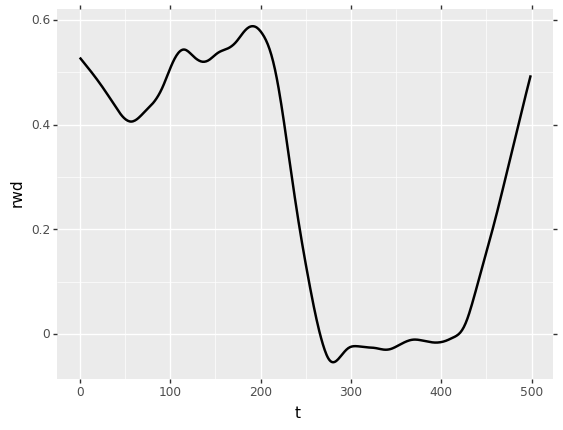

In [34]:
# Simulate regular q-learning.
model = qlearn(env = env, learning_rate = 0.1, epsilon = 0.05, gamma = 0)
model.learn(1)
model.plot(span = 0.2, obs = [1, 2])
print(np.round(model.q, 2))

[[ 0.   -0.  ]
 [ 0.    0.78]
 [ 0.   -0.44]
 [ 0.   -0.  ]
 [ 0.    0.  ]
 [ 0.   -0.  ]
 [ 0.   -0.53]
 [ 0.    1.09]
 [ 0.   -0.  ]
 [ 0.    0.  ]]


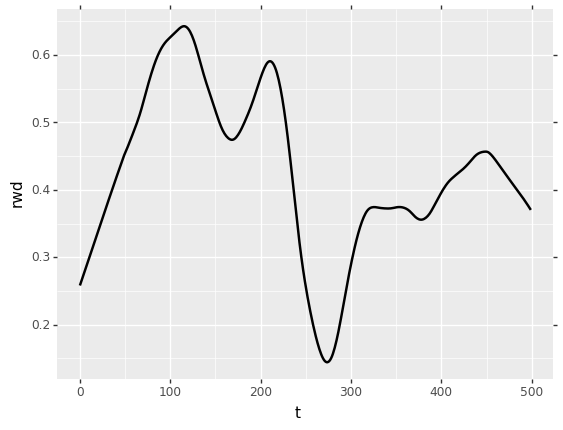

In [35]:
# Simulate belief state q-learning.
model = po_qlearn(env = env, pomdp = rev_pomdp, learning_rate = 0.1, epsilon = 0.05, gamma = 0)
model.learn(1)
model.plot(span = 0.2, obs = [1, 2])
print(np.round(model.q, 2))

[[ 0.   -0.  ]
 [ 0.    0.7 ]
 [ 0.   -0.34]
 [ 0.   -0.  ]
 [ 0.   -0.01]
 [ 0.   -0.  ]
 [ 0.   -0.93]
 [ 0.    1.05]
 [ 0.   -0.  ]
 [ 0.   -0.01]]


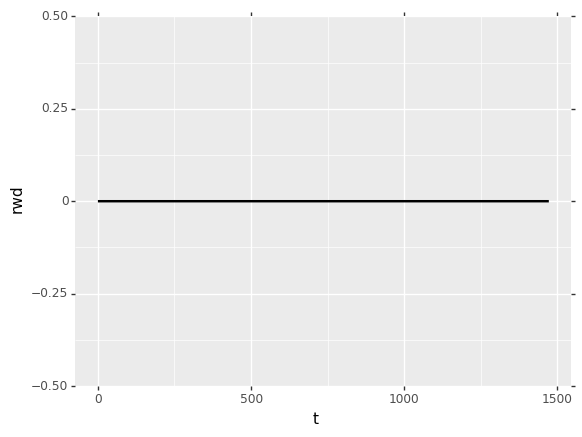

In [36]:
# Simulate POMDP Dyna-Q.
model = po_dynaq(env = env, pomdp = rev_pomdp, learning_rate = 0.1, epsilon = 0.05, gamma = 0, n_dyna = 1)
model.learn(1)
model.plot(span = 0.2, obs = [1, 2])
print(np.round(model.q, 2))

initial learning
-2.42
0.0204

reversal
8.82
0.0


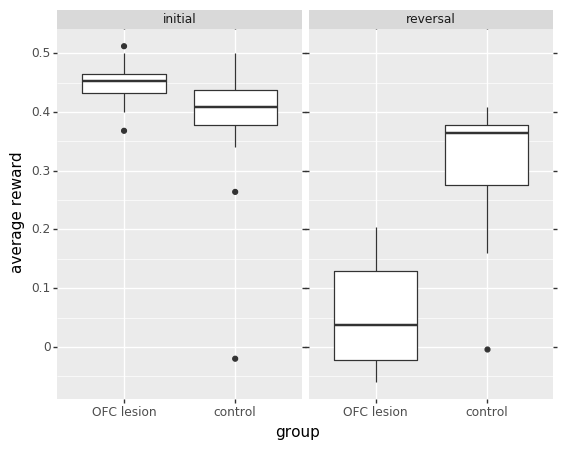

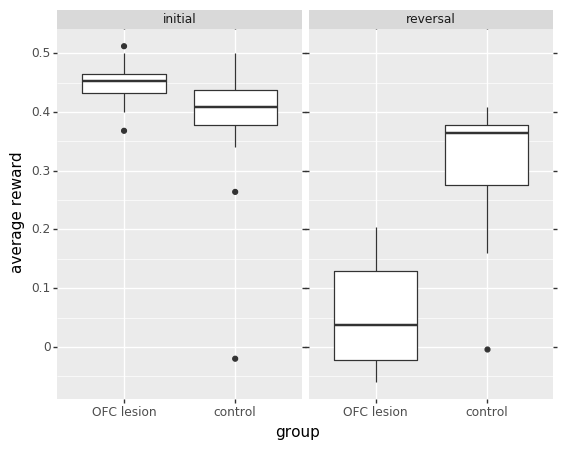

In [37]:
# Compare regular and POMDP q-learning.
rwd_ctrl = []
rwd_lesion = []
rwd_ctrl0 = []
rwd_lesion0 = []
rwd_ctrl1 = []
rwd_lesion1 = []
for i in range(n_rats):
    #model = po_dynaq(env = env, pomdp = rev_pomdp, learning_rate = 0.1, epsilon = 0.05, gamma = 0.5, n_dyna = 0) # this performs very badly
    model = po_qlearn(env = env, pomdp = rev_pomdp, learning_rate = 0.1, epsilon = 0.05, gamma = 0.5)
    model.learn(1)
    rwd_keep = model.rwd_list.loc[model.obs_list.isin([1, 2])]
    rwd_ctrl += [rwd_keep]
    rwd_ctrl0 += [np.mean(rwd_keep[0:250])]
    rwd_ctrl1 += [np.mean(rwd_keep[250:])]
    model = qlearn(env = env, learning_rate = 0.1, epsilon = 0.05, gamma = 0.5)
    model.learn(1)
    rwd_keep = model.rwd_list.loc[model.obs_list.isin([1, 2])]
    rwd_lesion += [rwd_keep]
    rwd_lesion0 += [np.mean(rwd_keep[0:250])]
    rwd_lesion1 += [np.mean(rwd_keep[250:])]
df = pd.DataFrame({'average reward' : rwd_ctrl0 + rwd_lesion0 + rwd_ctrl1 + rwd_lesion1,
                       'group' : n_rats*['control'] + n_rats*['OFC lesion'] + n_rats*['control'] + n_rats*['OFC lesion'],
                       'stage' : (2*n_rats)*['initial'] + (2*n_rats)*['reversal']})

print('initial learning')
print(np.round(ttest_ind(rwd_ctrl0, rwd_lesion0).statistic, 2))
print(np.round(ttest_ind(rwd_ctrl0, rwd_lesion0).pvalue, 4))
print()
print('reversal')
print(np.round(ttest_ind(rwd_ctrl1, rwd_lesion1).statistic, 2))
print(np.round(ttest_ind(rwd_ctrl1, rwd_lesion1).pvalue, 4))
p = (ggplot(df, aes('group', 'average reward'))
 + geom_boxplot() + facet_wrap('~ stage'))
p.draw()